# 503 Figure 2

In this notebook, we assess the data and plot Figure 2 (global scenario assessment)

In [1]:
import pyam
import pandas as pd

import yaml
import os
import dotenv
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.transforms as mtransforms

import seaborn as sns

<IPython.core.display.Javascript object>

In [2]:
dotenv.load_dotenv()

True

Step 1: Read in the compiled metrics data as well as the list of illustrative mitigation pathways we want to assess.

In [3]:
ipcc_imp = [
    ('MESSAGEix-GLOBIOM 1.0', 'LowEnergyDemand_1.3_IPCC'),
    ('REMIND-MAgPIE 2.1-4.2','SusDev_SDP-PkBudg1000'),
    ('REMIND-MAgPIE 2.1-4.3','DeepElec_SSP2_ HighRE_Budg900')
]
ssp_variants = [
    ('IMAGE 3.2', 'SSP1_SPA1_19I_D_LB'),
    ('IMAGE 3.2',	'SSP1_SPA1_19I_LIRE_LB'),
    ('IMAGE 3.2',	'SSP1_SPA1_19I_RE_LB'),
    ('IMAGE 3.2',	'SSP2_SPA1_19I_D_LB'),
    ('IMAGE 3.2',	'SSP2_SPA1_19I_LIRE_LB'),
    ('IMAGE 3.2',	'SSP2_SPA1_19I_RE_LB'),
    #('REMIND 2.1', 'R2p1_SSP1-PkBudg900'),
    #('REMIND 2.1',	'R2p1_SSP2-PkBudg900'),
    #('REMIND 2.1',	'R2p1_SSP5-PkBudg900'),
    ('REMIND-MAgPIE 2.1-4.2', 'CEMICS_SSP1-1p5C-fullCDR'),
    ('REMIND-MAgPIE 2.1-4.2',	'CEMICS_SSP1-1p5C-minCDR'),
    ('REMIND-MAgPIE 2.1-4.2',	'CEMICS_SSP2-1p5C-fullCDR'),
    ('REMIND-MAgPIE 2.1-4.2',	'CEMICS_SSP2-1p5C-minCDR'),
]

In [4]:
all_scens = ipcc_imp + ssp_variants
all_scens

[('MESSAGEix-GLOBIOM 1.0', 'LowEnergyDemand_1.3_IPCC'),
 ('REMIND-MAgPIE 2.1-4.2', 'SusDev_SDP-PkBudg1000'),
 ('REMIND-MAgPIE 2.1-4.3', 'DeepElec_SSP2_ HighRE_Budg900'),
 ('IMAGE 3.2', 'SSP1_SPA1_19I_D_LB'),
 ('IMAGE 3.2', 'SSP1_SPA1_19I_LIRE_LB'),
 ('IMAGE 3.2', 'SSP1_SPA1_19I_RE_LB'),
 ('IMAGE 3.2', 'SSP2_SPA1_19I_D_LB'),
 ('IMAGE 3.2', 'SSP2_SPA1_19I_LIRE_LB'),
 ('IMAGE 3.2', 'SSP2_SPA1_19I_RE_LB'),
 ('REMIND-MAgPIE 2.1-4.2', 'CEMICS_SSP1-1p5C-fullCDR'),
 ('REMIND-MAgPIE 2.1-4.2', 'CEMICS_SSP1-1p5C-minCDR'),
 ('REMIND-MAgPIE 2.1-4.2', 'CEMICS_SSP2-1p5C-fullCDR'),
 ('REMIND-MAgPIE 2.1-4.2', 'CEMICS_SSP2-1p5C-minCDR')]

In [5]:
compiled_quantile_data = pd.read_excel(
    Path('../data/502_allC1.xlsx'),
    index_col=[0,1]
)

Step 2: Read in the novel CDR data.

In [6]:
novel_cdr = pyam.IamDataFrame(
    Path(
        '../data/100_novel_cdr.csv'
    )
)

pyam.core - INFO: Reading file ../data/100_novel_cdr.csv


In [7]:
novel_cdr.load_meta(
    Path(
        '../data/100_meta.xlsx'
    )
)

pyam.core - WARNING: Ignoring meta indicators for the following scenarios:
          model            scenario
0  GEM-E3_V2021      EN_NPi2020_500
1  GEM-E3_V2021  EN_NPi2020_600_COV
pyam.core - INFO: Found column 'exclude' in sheet 'meta', moved to attribute `IamDataFrame.exclude`.


In [8]:
novel_cdr.filter(
    Category='C1',
    inplace=True
)

Step 3: Read in the land CDR dataset.

In [9]:
land_cdr_all = pyam.IamDataFrame(
    Path(
        os.environ['GIDDEN_GASSER_DATA']
    )
)

pyam.core - INFO: Reading file /Users/gauravganti/Documents/databases/gidden_et_al_2022_ar6_reanalysis_data.xlsx
pyam.core - INFO: Found column 'exclude' in sheet 'meta', moved to attribute `IamDataFrame.exclude`.


In [10]:
land_cdr_all.load_meta(
    Path(
        '../data/100_meta.xlsx'
    ),
    ignore_conflict=True
)

pyam.core - WARNING: No meta indicators for the following scenarios:
         model       scenario
0  AIM/CGE 2.0        SSP1-26
1  AIM/CGE 2.0        SSP1-34
2  AIM/CGE 2.0        SSP1-45
3  AIM/CGE 2.0  SSP1-Baseline
4  AIM/CGE 2.0        SSP4-26
...
pyam.core - WARNING: Ignoring meta indicators for the following scenarios:
                model                 scenario
0  AIM/Hub-Global 2.0                     1.5C
1       C-ROADS-5.005  Ratchet-1.5-limCDR-noOS
2       C-ROADS-5.005        Ratchet-1.5-noCDR
3       C-ROADS-5.005   Ratchet-1.5-noCDR-noOS
4            GCAM 4.2                  SSP1-19
...
pyam.core - INFO: Found column 'exclude' in sheet 'meta', moved to attribute `IamDataFrame.exclude`.


In [11]:
land_cdr_c1 = (
    land_cdr_all
    .filter(
        Category='C1',
        region='World',
        variable='AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct'
    )
)

Step 4: Calculate the cumulative novel CDR between net zero CO2 and 2100 and add this to the quantile data.

In [12]:
novel_cumulative = (
    novel_cdr
    .timeseries()
    .apply(
        lambda x: pyam.timeseries.cumulative(
            x,
            first_year=novel_cdr.meta.loc[x.name[0:2], 'netzero|CO2'],
            last_year=2100
        ),
        axis=1
    )
)

In [13]:
novel_cumulative /= 1000

In [14]:
novel_cumulative = pd.DataFrame(novel_cumulative)

In [15]:
for (mod, scen) in compiled_quantile_data.index:
    try:
        compiled_quantile_data.loc[(mod,scen), 'cumulative_novel_scenario'] = (
            novel_cumulative.loc[pd.IndexSlice[mod, scen, :, :, :], 0].values[0]
        )
    except:
        print(mod, scen)

GEM-E3_V2021 EN_NPi2020_500
GEM-E3_V2021 EN_NPi2020_600_COV


Step 5: Calculate the cumulative land CDR.

In [16]:
land_cumulative = (
    land_cdr_c1
    .timeseries()
    .apply(
        lambda x: pyam.timeseries.cumulative(
            x,
            first_year=novel_cdr.meta.loc[x.name[0:2], 'netzero|CO2'],
            last_year=2100
        ),
        axis=1
    )
)

In [17]:
land_cumulative /= 1000

In [18]:
land_cumulative = pd.DataFrame(land_cumulative)

In [19]:
for (mod, scen) in compiled_quantile_data.index:
    try:
        compiled_quantile_data.loc[(mod,scen), 'cumulative_land_scenario'] = (
            land_cumulative.loc[pd.IndexSlice[mod, scen, :, :, :], 0].values[0]
        )
    except:
        print(mod, scen)

AIM/Hub-Global 2.0 1.5C
C-ROADS-5.005 Ratchet-1.5-limCDR-noOS
C-ROADS-5.005 Ratchet-1.5-noCDR
C-ROADS-5.005 Ratchet-1.5-noCDR-noOS
GCAM 4.2 SSP1-19
GEM-E3_V2021 EN_NPi2020_500
GEM-E3_V2021 EN_NPi2020_600_COV
POLES EMF33 EMF33_WB2C_cost100
POLES EMF33 EMF33_WB2C_full
POLES EMF33 EMF33_WB2C_nofuel
REMIND 1.7 ADVANCE_2020_1.5C-2100
REMIND 1.7 CEMICS-1.5-CDR12
REMIND 1.7 CEMICS-1.5-CDR20
REMIND 1.7 CEMICS-1.5-CDR8
REMIND 1.7 CEMICS-2.0-CDR8
REMIND 2.1 CEMICS_GDPgrowth_1p5
REMIND 2.1 CEMICS_HotellingConst_1p5
REMIND 2.1 CEMICS_Linear_1p5
REMIND 2.1 CEMICS_opt_1p5
REMIND 2.1 LeastTotalCost_LTC_brkLR15_SSP1_P50
REMIND 2.1 R2p1_SSP1-PkBudg900
REMIND 2.1 R2p1_SSP2-PkBudg900
REMIND 2.1 R2p1_SSP5-PkBudg900
REMIND-MAgPIE 2.1-4.2 NGFS2_Net-Zero 2050 - IPD-95th
REMIND-MAgPIE 2.1-4.2 NGFS2_Net-Zero 2050 - IPD-median
WITCH-GLOBIOM 3.1 SSP1-19
WITCH-GLOBIOM 3.1 SSP4-19


In [20]:
compiled_quantile_data.loc[:, 'cumulative_total_scenario'] = (
    compiled_quantile_data['cumulative_novel_scenario']
    + compiled_quantile_data['cumulative_land_scenario']
)

In [21]:
compiled_quantile_data

p50  p50_2100_warming       p67  \
model              scenario                                                   
AIM/CGE 2.1        CD-LINKS_NPi2020_400     0.0          1.236271    0.0000   
AIM/CGE 2.2        EN_NPi2020_300f          0.0          1.303397    0.0000   
                   EN_NPi2020_600           0.4          1.478590  192.3165   
AIM/Hub-Global 2.0 1.5C                     0.0          1.251677    0.0000   
C-ROADS-5.005      Ratchet-1.5-limCDR-noOS  0.0          1.117258    0.0000   
...                                         ...               ...       ...   
WITCH 5.0          EN_NPi2020_500f          0.0          1.471612  339.7920   
WITCH-GLOBIOM 3.1  SSP1-19                  0.0          1.264723    0.0000   
                   SSP4-19                  0.0          1.188809    0.0000   
WITCH-GLOBIOM 4.4  CD-LINKS_NPi2020_1000    0.0          1.336467    0.0000   
                   CD-LINKS_NPi2020_400     0.0          1.018260    0.0000   

                                            p67_2100_warming       p90  \
model              scenario                                              
AIM/CGE 2.1        CD-LINKS_NPi2020_400             1.375203   408.827   
AIM/CGE 2.2        EN_NPi2020_300f                  1.428395   456.253   
                   EN_NPi2020_600                   1.615572   857.129   
AIM/Hub-Global 2.0 1.5C                             1.375733   395.764   
C-ROADS-5.005      Ratchet-1.5-limCDR-noOS          1.258132   220.843   
...                                                      ...       ...   
WITCH 5.0          EN_NPi2020_500f                  1.672104  1127.109   
WITCH-GLOBIOM 3.1  SSP1-19                          1.418482   519.020   
                   SSP4-19                          1.307240   236.023   
WITCH-GLOBIOM 4.4  CD-LINKS_NPi2020_1000            1.473968   705.624   
                   CD-LINKS_NPi2020_400             1.123190     0.000   

                                            p90_2100_warming Category_subset  \
model              scenario                                                    
AIM/CGE 2.1        CD-LINKS_NPi2020_400             1.750101      C1a_NZGHGs   
AIM/CGE 2.2        EN_NPi2020_300f                  1.807699      C1a_NZGHGs   
                   EN_NPi2020_600                   2.023190     C1b_+veGHGs   
AIM/Hub-Global 2.0 1.5C                             1.742176      C1a_NZGHGs   
C-ROADS-5.005      Ratchet-1.5-limCDR-noOS          1.627219      C1a_NZGHGs   
...                                                      ...             ...   
WITCH 5.0          EN_NPi2020_500f                  2.162365      C1a_NZGHGs   
WITCH-GLOBIOM 3.1  SSP1-19                          1.800749      C1a_NZGHGs   
                   SSP4-19                          1.646548      C1a_NZGHGs   
WITCH-GLOBIOM 4.4  CD-LINKS_NPi2020_1000            1.892603      C1a_NZGHGs   
                   CD-LINKS_NPi2020_400             1.431761      C1a_NZGHGs   

                                            cum_grossemico2_after_netzero_gtco2  \
model              scenario                                                       
AIM/CGE 2.1        CD-LINKS_NPi2020_400                              278.722779   
AIM/CGE 2.2        EN_NPi2020_300f                                   336.951137   
                   EN_NPi2020_600                                    531.936710   
AIM/Hub-Global 2.0 1.5C                                              224.653681   
C-ROADS-5.005      Ratchet-1.5-limCDR-noOS                            47.842713   
...                                                                         ...   
WITCH 5.0          EN_NPi2020_500f                                   298.080554   
WITCH-GLOBIOM 3.1  SSP1-19                                           362.106991   
                   SSP4-19                                           367.774696   
WITCH-GLOBIOM 4.4  CD-LINKS_NPi2020_1000                             192.111292   
                

Step 6: Out of curiosity - scatter p90 and total

<Axes: xlabel='cumulative_total_scenario', ylabel='p90'>

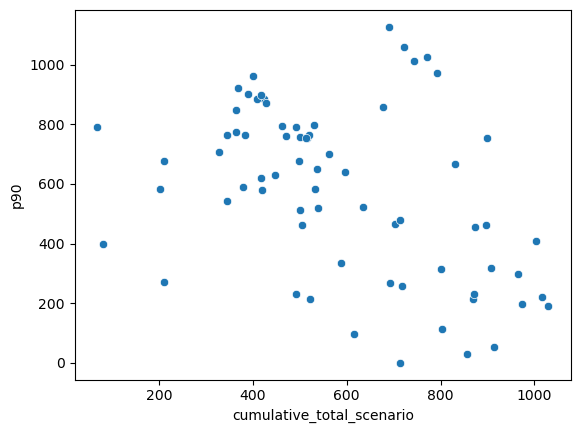

In [22]:
sns.scatterplot(
    x='cumulative_total_scenario',
    y='p90',
    data=compiled_quantile_data
)

In [23]:
ipcc_imp

[('MESSAGEix-GLOBIOM 1.0', 'LowEnergyDemand_1.3_IPCC'),
 ('REMIND-MAgPIE 2.1-4.2', 'SusDev_SDP-PkBudg1000'),
 ('REMIND-MAgPIE 2.1-4.3', 'DeepElec_SSP2_ HighRE_Budg900')]

In [24]:
ssp_variants

[('IMAGE 3.2', 'SSP1_SPA1_19I_D_LB'),
 ('IMAGE 3.2', 'SSP1_SPA1_19I_LIRE_LB'),
 ('IMAGE 3.2', 'SSP1_SPA1_19I_RE_LB'),
 ('IMAGE 3.2', 'SSP2_SPA1_19I_D_LB'),
 ('IMAGE 3.2', 'SSP2_SPA1_19I_LIRE_LB'),
 ('IMAGE 3.2', 'SSP2_SPA1_19I_RE_LB'),
 ('REMIND-MAgPIE 2.1-4.2', 'CEMICS_SSP1-1p5C-fullCDR'),
 ('REMIND-MAgPIE 2.1-4.2', 'CEMICS_SSP1-1p5C-minCDR'),
 ('REMIND-MAgPIE 2.1-4.2', 'CEMICS_SSP2-1p5C-fullCDR'),
 ('REMIND-MAgPIE 2.1-4.2', 'CEMICS_SSP2-1p5C-minCDR')]

Step 7: Read in the compiled emission input.

In [25]:
df_emissions = pd.read_csv(
    Path(
        '../data/100_scenarios.csv'
    ),
    index_col=[0,1]
)

In [26]:
df_emissions_illustrative = pyam.IamDataFrame(
    df_emissions
    .loc[all_scens, :]
    .reset_index()
)
df_emissions_illustrative.swap_time_for_year(inplace=True)

In [27]:
df_emissions_illustrative.filter(
    variable=[
        'AR6 climate diagnostics|Infilled|Emissions|CO2',
        'AR6 climate diagnostics|Infilled|Emissions|CH4',
        'AR6 climate diagnostics|Infilled|Emissions|N2O'
    ],
    inplace=True
)

In [28]:
for (mod, scen) in df_emissions_illustrative.meta.index:
    to_concat_novel = novel_cdr.filter(
        model=mod,
        scenario=scen
    )
    to_concat_land = land_cdr_c1.filter(
        model=mod,
        scenario=scen
    )
    df_emissions_illustrative = pyam.concat(
        [
            df_emissions_illustrative,
            to_concat_novel,
            to_concat_land
        ],
        ignore_meta_conflict=True
    )

In [29]:
df_emissions_illustrative.filter(
    year=range(2020, 2101),
    inplace=True
)

In [30]:
df_emissions_illustrative.interpolate(
    time=range(2020, 2101),
    inplace=True
)

In [31]:
df_emissions_illustrative.add(
    a='AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct',
    b='Carbon Dioxide Removal|Novel',
    ignore_units='Mt CO2/yr',
    name='Carbon Dioxide Removal',
    append=True
)

pyam.plotting - INFO: >=13 labels, not applying legend


<Axes: title={'center': 'region: World - variable: Carbon Dioxide Removal'}, xlabel='Year', ylabel='Mt CO2/yr'>

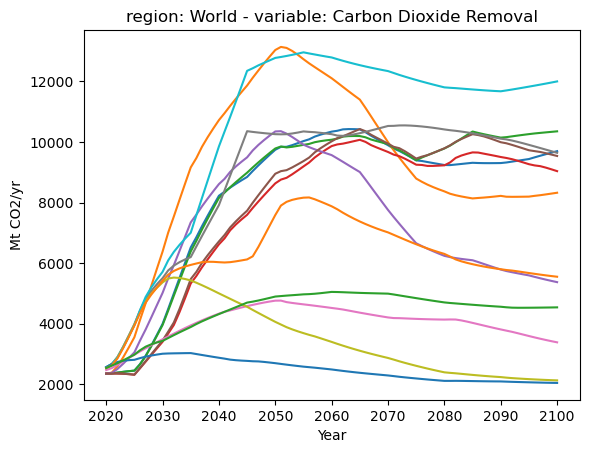

In [32]:
df_emissions_illustrative.filter(variable='Carbon Dioxide Removal').plot()

In [33]:
df_emissions_illustrative.add(
    a='AR6 climate diagnostics|Infilled|Emissions|CO2',
    b='Carbon Dioxide Removal',
    name='Gross CO2 emissions',
    ignore_units='Mt CO2/yr',
    append=True
)

In [34]:
df_emissions_illustrative.unit_mapping

{'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct': 'Mt CO2/yr',
 'AR6 climate diagnostics|Infilled|Emissions|CH4': 'Mt CH4/yr',
 'AR6 climate diagnostics|Infilled|Emissions|CO2': 'Mt CO2/yr',
 'AR6 climate diagnostics|Infilled|Emissions|N2O': 'kt N2O/yr',
 'Carbon Dioxide Removal': 'Mt CO2/yr',
 'Carbon Dioxide Removal|Novel': 'Mt CO2/yr',
 'Gross CO2 emissions': 'Mt CO2/yr'}

In [35]:
df_emissions_illustrative.convert_unit(
    current='kt N2O/yr',
    to='Gt CO2-equiv/yr',
    context='AR6GWP100',
    inplace=True
)

In [36]:
df_emissions_illustrative.convert_unit(
    current='Mt CO2/yr',
    to='Gt CO2-equiv/yr',
    #context='AR6GWP100',
    inplace=True
)

In [37]:
df_emissions_illustrative.convert_unit(
    current='Mt CH4/yr',
    to='Gt CO2-equiv/yr',
    context='AR6GWP100',
    inplace=True
)

In [38]:
df_emissions_illustrative.add(
    a='Gross CO2 emissions',
    b='AR6 climate diagnostics|Infilled|Emissions|N2O',
    name='Gross CO2 and N2O emissions',
    ignore_units='Gt CO2-equiv/yr',
    append=True
)

In [39]:
df_emissions_illustrative.load_meta(
    Path(
        '../data/100_meta.xlsx'
    ),
    ignore_conflict=True
)

pyam.core - WARNING: Ignoring meta indicators for the following scenarios:
                model                 scenario
0         AIM/CGE 2.1     CD-LINKS_NPi2020_400
1         AIM/CGE 2.2          EN_NPi2020_300f
2         AIM/CGE 2.2           EN_NPi2020_600
3  AIM/Hub-Global 2.0                     1.5C
4       C-ROADS-5.005  Ratchet-1.5-limCDR-noOS
...
pyam.core - INFO: Found column 'exclude' in sheet 'meta', moved to attribute `IamDataFrame.exclude`.


Step 8: Now we want to add the following information to the metadata (for plotting):
* Cumulative gross CO2 and N2O emissions between net zero and 2100
* Level of CH4 emissions in 2100 (twin x)

In [40]:
(
    df_emissions_illustrative.filter(
            variable='Gross CO2 and N2O emissions'
        )
        .timeseries()
        .apply(
            lambda x: pyam.timeseries.cumulative(
                x,
                first_year=df_emissions_illustrative.meta.loc[x.name[0:2], 'netzero|CO2'],
                last_year=2100
            ),
            axis=1
        )
    )

model                  scenario                       region  variable                     unit           
IMAGE 3.2              SSP1_SPA1_19I_D_LB             World   Gross CO2 and N2O emissions  Gt CO2-equiv/yr    383.802713
                       SSP1_SPA1_19I_LIRE_LB          World   Gross CO2 and N2O emissions  Gt CO2-equiv/yr    369.529180
                       SSP1_SPA1_19I_RE_LB            World   Gross CO2 and N2O emissions  Gt CO2-equiv/yr    354.288503
                       SSP2_SPA1_19I_D_LB             World   Gross CO2 and N2O emissions  Gt CO2-equiv/yr    421.940956
                       SSP2_SPA1_19I_LIRE_LB          World   Gross CO2 and N2O emissions  Gt CO2-equiv/yr    365.431346
                       SSP2_SPA1_19I_RE_LB            World   Gross CO2 and N2O emissions  Gt CO2-equiv/yr    385.141086
MESSAGEix-GLOBIOM 1.0  LowEnergyDemand_1.3_IPCC       World   Gross CO2 and N2O emissions  Gt CO2-equiv/yr    126.413074
REMIND-MAgPIE 2.1-4.2  CEMICS_SSP1-1p5C-fullCD

In [41]:
df_emissions_illustrative.set_meta(
    (
        df_emissions_illustrative
        .filter(
            variable='Gross CO2 and N2O emissions'
        )
        .timeseries()
        .apply(
            lambda x: pyam.timeseries.cumulative(
                x,
                first_year=df_emissions_illustrative.meta.loc[x.name[0:2], 'netzero|CO2'],
                last_year=2100
            ),
            axis=1
        )
    ),
    name='cumulative_gross'
)

In [42]:
df_emissions_illustrative.set_meta_from_data(
    variable='AR6 climate diagnostics|Infilled|Emissions|CH4',
    year=2100,
    name='ch4_2100'
)

In [43]:
data_panelc_onwards = df_emissions_illustrative.meta[['cumulative_gross', 'ch4_2100']]

Step mm: Start plotting the figure.

In [44]:
ssp_variant_color = {
    'IMAGE 3.2': 'red',
    'REMIND 2.1': 'blue',
    'REMIND-MAgPIE 2.1-4.2': 'green'
}

In [45]:
imp_marker = {
    'LowEnergyDemand_1.3_IPCC': '^',
    'SusDev_SDP-PkBudg1000': 'o',
    'DeepElec_SSP2_ HighRE_Budg900': 's'
}

In [46]:
ipcc_imp_colors_panel_c = {
    'LowEnergyDemand_1.3_IPCC': '#a5917f',
    'SusDev_SDP-PkBudg1000': '#4dbdab',
    'DeepElec_SSP2_ HighRE_Budg900': '#7688ab'
}

In [47]:
compiled_quantile_data['total_cdr_target'] = (
    compiled_quantile_data['cumulative_total_scenario']
    +
    compiled_quantile_data['p90']
)

In [48]:
compiled_quantile_data['p90'].describe().round(0)

count      95.0
mean      532.0
std       287.0
min         0.0
25%       269.0
50%       569.0
75%       762.0
max      1127.0
Name: p90, dtype: float64

In [49]:
compiled_quantile_data['cumulative_total_scenario'].describe().round(0)

count      70.0
mean      585.0
std       231.0
min        68.0
25%       418.0
50%       532.0
75%       763.0
max      1030.0
Name: cumulative_total_scenario, dtype: float64

In [50]:
plt.rcParams.update({'font.size': 20})

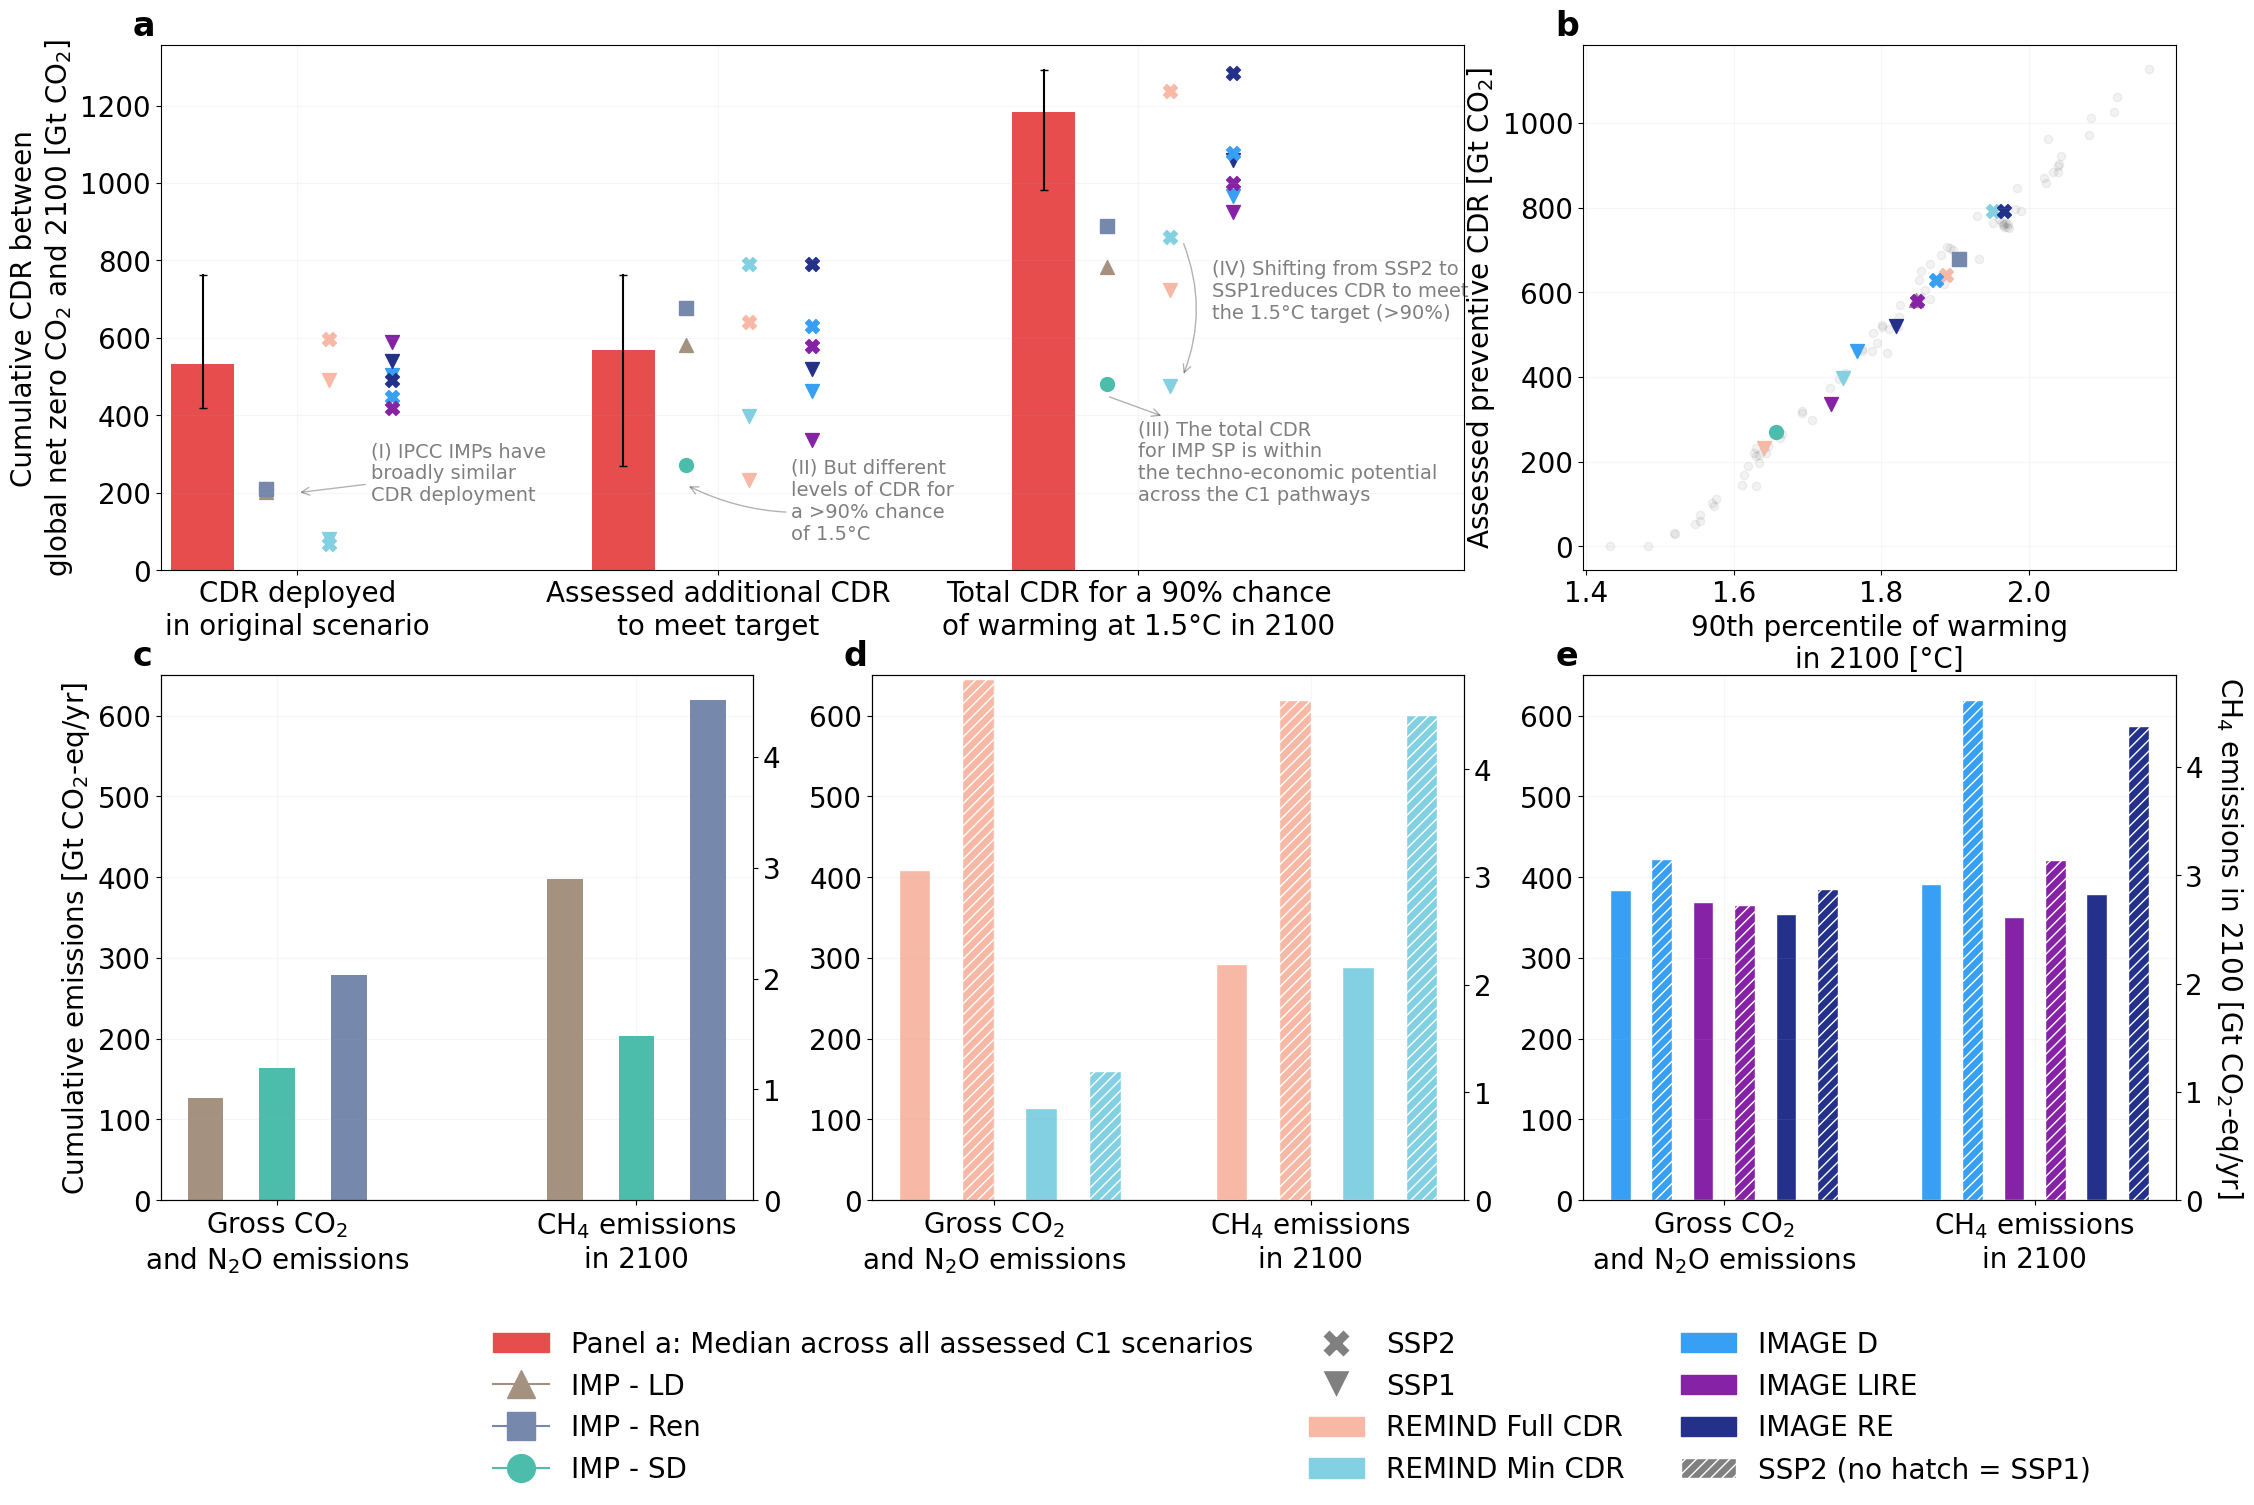

In [51]:
fig2, ax2 = plt.subplot_mosaic(
    mosaic=[
        ['a', 'a', 'b'],
        ['c', 'd', 'e']
    ],
    figsize=(26, 15)
)

# Panel a and b - plotting the total, scenario, and p90
xvals = compiled_quantile_data['p90_2100_warming']
yvals = compiled_quantile_data['p90']
ax2['b'].scatter(
    x=xvals,
    y=yvals,
    color='black',
    alpha=0.05
)
ssp_marker = {
    'SSP2':'X',
    'SSP1': 'v'
}
remind_scen_colors = {
    'fullCDR':'#f7b9a6',
    'minCDR':'#83d0e2' 
}
image_scen_colors = {
    'SPA1_19I_D_LB':'#37a0f4',
    'SPA1_19I_LIRE_LB': '#8622a6',
    'SPA1_19I_RE_LB':'#23318a' 
}

for i, col in enumerate(['cumulative_total_scenario', 'p90', 'total_cdr_target']):
    vals = compiled_quantile_data[col].dropna()
    n = len(vals)
    ax2['a'].bar(
        x=i,
        bottom=0,
        height=vals.median(),
        width=0.15,
        color='#e74d4d'
    )
    ax2['a'].errorbar(
        x=[i, i],
        y=[vals.quantile(0.25), vals.quantile(0.75)],
        marker='_',
        color='black'
    )
    # Now plot the different IMPs
    for (mod, scen) in ipcc_imp:
        ax2['a'].scatter(
            x=i+0.15,
            y=vals.loc[(mod, scen)],
            marker=imp_marker[scen],
            color=ipcc_imp_colors_panel_c[scen],
            s=100
        )
        if i == 0:
            ax2['b'].scatter(
                x=xvals.loc[(mod, scen)],
                y=yvals.loc[(mod, scen)],
                marker=imp_marker[scen],
                color=ipcc_imp_colors_panel_c[scen],
                s=100
            )
        
    # Now plot the REMIND SSP variants
    mod = 'REMIND-MAgPIE 2.1-4.2'
    for scen in ['fullCDR', 'minCDR']:
        for ssp in ['SSP1', 'SSP2']:
            scen_comp = f'CEMICS_{ssp}-1p5C-{scen}'
            ax2['a'].scatter(
                x=i+0.3,
                y=vals.loc[(mod, scen_comp)],
                marker=ssp_marker[ssp],
                color=remind_scen_colors[scen],
                s=100
            )
            if i == 0:
                ax2['b'].scatter(
                    x=xvals.loc[(mod, scen_comp)],
                    y=yvals.loc[(mod, scen_comp)],
                    marker=ssp_marker[ssp],
                    color=remind_scen_colors[scen],
                    s=100
                )
    mod = 'IMAGE 3.2'
    for ssp in ['SSP1', 'SSP2']:
        for scen in image_scen_colors.keys():
            scen_comp = f'{ssp}_{scen}'
            ax2['a'].scatter(
                x=i+0.45,
                y=vals.loc[(mod, scen_comp)],
                marker=ssp_marker[ssp],
                color=image_scen_colors[scen],
                s=100
            )
            if i == 0:
                ax2['b'].scatter(
                    x=xvals.loc[(mod, scen_comp)],
                    y=yvals.loc[(mod, scen_comp)],
                    marker=ssp_marker[ssp],
                    color=image_scen_colors[scen],
                    s=100
                )

ax2['a'].set_xticks(
    [0.225, 1.225, 2.225], 
    labels=[
        'CDR deployed\nin original scenario',
        'Assessed additional CDR\nto meet target',
        'Total CDR for a 90% chance\nof warming at 1.5°C in 2100',
    ]
)
ax2['a'].grid(alpha=0.1)
ax2['a'].set_ylabel('Cumulative CDR between\nglobal net zero CO$_2$ and 2100 [Gt CO$_2$]')
ax2['b'].set_ylabel(
    'Assessed preventive CDR [Gt CO$_2$]'
)
ax2['b'].set_xlabel(
    '90th percentile of warming\nin 2100 [°C]'
)
ax2['b'].grid(alpha=0.1)
## Now, let us start adding in the annotations
ax2['a'].annotate(
    '(I) IPCC IMPs have\nbroadly similar\nCDR deployment', 
    xy=(0.225, 200), 
    xytext=(0.4, 180), 
    fontsize=14,
    xycoords='data', 
    textcoords='data',
    arrowprops=dict(facecolor='grey', arrowstyle='->', alpha=0.3),
    alpha=0.5,
)
ax2['a'].annotate(
    '(II) But different\nlevels of CDR for\na >90% chance\nof 1.5°C',
    xy=(1.15, 220),
    xytext=(1.4, 80),
    fontsize=14,
    xycoords='data',
    textcoords='data',
    arrowprops=dict(facecolor='grey', arrowstyle='->', alpha=0.3, connectionstyle='arc3,rad=-0.2'),
    alpha=0.5
)
ax2['a'].annotate(
    '(III) The total CDR\nfor IMP SP is within\nthe techno-economic potential\nacross the C1 pathways',
    xy=(2.15, 450),
    xytext=(2.225, 180),
    xycoords='data',
    fontsize=14,
    textcoords='data',
    arrowprops=dict(facecolor='grey', arrowstyle='<-', alpha=0.3),
    alpha=0.5
)
#### Issue - we need to think about the annotation!
ax2['a'].set_xlim(-0.1, 3)
ax2['a'].annotate(
    '',
    xy= (2.33, 850),
    xytext=(2.33, 500),
    fontsize=14,
    arrowprops=dict(facecolor='grey', arrowstyle='<-', alpha=0.3, connectionstyle='arc3,rad=0.2'),
    alpha=0.5
)
ax2['a'].annotate(
    '(IV) Shifting from SSP2 to\nSSP1reduces CDR to meet\nthe 1.5°C target (>90%)',
    xy=(2.4, 650),
    xytext=(2.4, 650),
    fontsize=14,
    alpha=0.5
)

# Make a custom legend explaining all the colors
legend_elements = [
    Patch(facecolor='#e74d4d', edgecolor='#e74d4d', label='Panel a: Median across all assessed C1 scenarios'),
    Line2D([0], [0], marker=imp_marker['LowEnergyDemand_1.3_IPCC'], color=ipcc_imp_colors_panel_c['LowEnergyDemand_1.3_IPCC'], label='IMP - LD', markerfacecolor=ipcc_imp_colors_panel_c['LowEnergyDemand_1.3_IPCC'], markersize=20),
    Line2D([0], [0], marker=imp_marker['DeepElec_SSP2_ HighRE_Budg900'], color=ipcc_imp_colors_panel_c['DeepElec_SSP2_ HighRE_Budg900'], label='IMP - Ren', markerfacecolor=ipcc_imp_colors_panel_c['DeepElec_SSP2_ HighRE_Budg900'], markersize=20),
    Line2D([0], [0], marker=imp_marker['SusDev_SDP-PkBudg1000'], color=ipcc_imp_colors_panel_c['SusDev_SDP-PkBudg1000'], label='IMP - SD', markerfacecolor=ipcc_imp_colors_panel_c['SusDev_SDP-PkBudg1000'], markersize=20),
    Line2D([0], [0], marker='X', color='w', label='SSP2', markerfacecolor='grey', markersize=20),
    Line2D([0], [0], marker='v', color='w', label='SSP1', markerfacecolor='grey', markersize=20),
    Patch(facecolor='#f7b9a6', edgecolor='#f7b9a6', label='REMIND Full CDR'),
    Patch(facecolor='#83d0e2', edgecolor='#83d0e2', label='REMIND Min CDR'),
    Patch(facecolor='#37a0f4', edgecolor='#37a0f4', label='IMAGE D'),
    Patch(facecolor='#8622a6', edgecolor='#8622a6', label='IMAGE LIRE'),
    Patch(facecolor='#23318a', edgecolor='#23318a', label='IMAGE RE'),
    Patch(facecolor='grey', hatch='///', edgecolor='white', label='SSP2 (no hatch = SSP1)'),
]

# Panel C - plotting the gross CO2 nd N2O and the Ch4 level in 2100.
i = -0.2
ax_twin = ax2['c'].twinx()
for (mod, scen) in ipcc_imp:
    ax2['c'].bar(
        x=i,
        height=data_panelc_onwards.loc[(mod, scen), 'cumulative_gross'],
        width=0.1,
        color=ipcc_imp_colors_panel_c[scen]
    )
    ax_twin.bar(
        x=i+1,
        bottom=0,
        height=data_panelc_onwards.loc[(mod, scen), 'ch4_2100'],
        width=0.1,
        color=ipcc_imp_colors_panel_c[scen]
    )
    i += 0.2

for a in [ax2['c'], ax2['d'], ax2['e']]:
    a.set_ylim(0, 650)
    a.grid(alpha=0.1)

hatch = {
    'SSP1': None,
    'SSP2': '///'
}
i = -0.25
ax3_twin = ax2['d'].twinx()
mod='REMIND-MAgPIE 2.1-4.2'
for scen in ['fullCDR', 'minCDR']:
    for ssp in ['SSP1', 'SSP2']:
        scen_comp = f'CEMICS_{ssp}-1p5C-{scen}'
        ax2['d'].bar(
            x=i,
            height=data_panelc_onwards.loc[(mod, scen_comp), 'cumulative_gross'],
            width=0.1,
            color=remind_scen_colors[scen],
            hatch=hatch[ssp],
            edgecolor='white'
        )
        ax3_twin.bar(
            x=i+1,
            bottom=0,
            height=data_panelc_onwards.loc[(mod, scen_comp), 'ch4_2100'],
            width=0.1,
            color=remind_scen_colors[scen],
            hatch=hatch[ssp],
            edgecolor='white'
        )
        i += 0.2
i = -1
ax4 = ax2['e'].twinx()
mod = 'IMAGE 3.2'
for scen in ['SPA1_19I_D_LB', 'SPA1_19I_LIRE_LB', 'SPA1_19I_RE_LB']:
    for ssp in ['SSP1', 'SSP2']:
        scen_comp = f'{ssp}_{scen}'
        ax2['e'].bar(
            x=i,
            height=data_panelc_onwards.loc[(mod, scen_comp), 'cumulative_gross'],
            width=0.1,
            color=image_scen_colors[scen],
            hatch=hatch[ssp],
            edgecolor='white'
        )
        ax4.bar(
            x=i+1.5,
            bottom=0,
            height=data_panelc_onwards.loc[(mod, scen_comp), 'ch4_2100'],
            width=0.1,
            color=image_scen_colors[scen],
            hatch=hatch[ssp],
            edgecolor='white'
        )
        i += 0.2

ax4.set_ylabel('CH$_4$ emissions in 2100 [Gt CO$_2$-eq/yr]', rotation=270, labelpad=30)
ax2['d'].legend(
    handles=legend_elements,
    ncol=3,
    bbox_to_anchor=(2.1, -0.2),
    frameon=False
)
ax2['c'].set_ylabel('Cumulative emissions [Gt CO$_2$-eq/yr]')

ax2['c'].set_xticks([0, 1], labels=['Gross CO$_2$\nand N$_2$O emissions', 'CH$_4$ emissions\nin 2100'])
ax2['d'].set_xticks([0, 1], labels=['Gross CO$_2$\nand N$_2$O emissions', 'CH$_4$ emissions\nin 2100'])
ax2['e'].set_xticks([-0.5, 1], labels=['Gross CO$_2$\nand N$_2$O emissions', 'CH$_4$ emissions\nin 2100'])


for label, a in ax2.items():
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig2.dpi_scale_trans)
    a.text(0.0, 1.0, label, transform=a.transAxes + trans, weight='bold', fontsize='large')  

In [52]:
fig2.savefig(
    Path('../results/Figure2.png'),
    dpi=600,
    bbox_inches='tight'
)

## Statements

In [53]:
print(
    f"""
    At the global level, around {compiled_quantile_data['cumulative_total_scenario'].quantile(q=0.5).round(0)} Gt CO2 of CDR 
    (median, with [{compiled_quantile_data['cumulative_total_scenario'].quantile(q=0.25).round(0)}, {compiled_quantile_data['cumulative_total_scenario'].quantile(q=0.75).round(0)}] 
    interquartile range) is cumulatively deployed 
    between global net zero CO2 and 2100 in the assessed scenarios (i.e., the scenario uncertainty).
    """
)


    At the global level, around 532.0 Gt CO2 of CDR 
    (median, with [418.0, 763.0] 
    interquartile range) is cumulatively deployed 
    between global net zero CO2 and 2100 in the assessed scenarios (i.e., the scenario uncertainty).
    


IMP Ren

In [54]:
compiled_quantile_data.loc[ipcc_imp[2],'total_cdr_target'].round(0)

888.0

In [55]:
compiled_quantile_data.loc[ipcc_imp[0],'total_cdr_target'].round(0)

784.0

In [56]:
compiled_quantile_data.loc[ipcc_imp[1],'total_cdr_target'].round(0)

482.0

In [57]:
data_panelc_onwards.loc[ipcc_imp, :].round(1)

,,cumulative_gross,ch4_2100
model,scenario,,
MESSAGEix-GLOBIOM 1.0,LowEnergyDemand_1.3_IPCC,126.4,2.9
REMIND-MAgPIE 2.1-4.2,SusDev_SDP-PkBudg1000,164.0,1.5
REMIND-MAgPIE 2.1-4.3,DeepElec_SSP2_ HighRE_Budg900,278.2,4.5
